In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load in Exercise Data

In [2]:
exercise = pd.read_csv('data/exercise.csv')
calories = pd.read_csv('data/calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df['Intercept'] = 1
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


# Plot Relationship

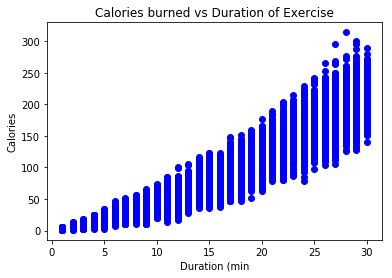

In [3]:
plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min'); plt.ylabel('Calories'); plt.title('Calories burned vs Duration of Exercise');

In [4]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.ix[:, 'Calories']

# Implementing Linear Regression by Hand

In [5]:
# Takes a matrix of features (with intercept as first column) 
# and response vector and calculates linear regression coefficients
def linear_regression(X, y):
    # Equation for linear regression coefficients
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    return beta

In [6]:
# Run the by hand implementation
by_hand_coefs = linear_regression(X, y)
print('Intercept calculated by hand:', by_hand_coefs[0])
print('Slope calculated by hand: ', by_hand_coefs[1])

Intercept calculated by hand: -21.859656399672385
Slope calculated by hand:  7.172883837907462


# Verify with Sklearn Implementation

In [7]:
from sklearn.linear_model import LinearRegression

# Create the model and fit on the data
lr = LinearRegression()
lr.fit(X.Duration.reshape(-1, 1), y)
print('Intercept from library:', lr.intercept_)
print('Slope from library:', lr.coef_)

Intercept from library: -21.859656399672403
Slope from library: [7.17288384]


# Bayesian Linear Regression

## Using PyMC3 and N-UTurn Sampling (NUTS)

Implement MCMC to find the posterior distribution of the model parameters. Rather than a single point estimate of the model weights, Bayesian linear regression will give us a posterior distribution for the model weights.

In [8]:
# Dataframe with response included
X_with_labels = X.copy()
X_with_labels['Calories'] = y.values

In [ ]:
with pm.Model() as linear_model:
    # Use the formula syntax to specify equation
    pm.GLM.from_formula('Calories ~ Duration', data = X_with_labels, family = pm.families.Normal())
    
    # Sample from the posterior 1500 times with 500 burn-in steps 
    linear_trace = pm.sample(draws=1500, tune=500, chains=2, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, Duration, Intercept]


# Bayesian Model Results

## Trace of All Model Parameters

In [ ]:
pm.traceplot(linear_trace);

## Posterior Distribution of Model Parameteres

In [ ]:
pm.plot_posterior(linear_trace);

## Confidence Intervals for Model Parameters

In [ ]:
pm.forestplot(linear_trace);

# Predictions of Response Sampled from the Posterior

We can now generate predictions of the linear regression line using the model results. The following plot shows 1000 different estimates of the regression line drawn from the posterior. The distribution of the lines gives an estimate of the uncertainty in the estimate. Bayesian Linear Regression has the benefit that it gives us a posterior __distribution__ rather than a __single point estimate__ in the frequentist ordinary least squares regression.

In [ ]:
linear_trace['Intercept'].mean()

In [ ]:
linear_trace['Duration'].mean()

In [ ]:
pm.plot_posterior_predictive_glm(linear_trace, samples = 1000, eval=np.linspace(0, 30, 100),
                                lm = lambda x, sample: sample['Intercept'] + sample['Duration'] * x);

In [ ]:
pm.df_summary(linear_trace)